# Pairs Trading Project_Raw Material price - Cointegration

### Motivation:

- Security A - (Something Correlated to it) is more mean-reverting. Similar securties should trade similarily. Hence, any discrepancies between the correlated pairs should converge.
- When there is a discrepancy, we form a long-short spread trade and bet on the discrepancy converging.
- Pairs trading is one of the most popular statistical arbitrage strategies in traditional markets. We want to test the performance of this strategy in the raw material market, as it is still relatively new and should be fertile grounds for finding market inefficiencies.
- We will use cointegration to find similar pairs as it is a robust statistical approach for identifying long-term equilibrium relationships between assetsfrom datetime import datetime.

In [30]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import plotly.express as px

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from collections import Counter

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from joblib import Parallel, delayed
from itertools import combinations
from IPython.display import display, Javascript

In [31]:
pip install pandas numpy seaborn matplotlib plotly statsmodels scikit-learn yellowbrick joblib ipython

Note: you may need to restart the kernel to use updated packages.


### Step 0: Data Cleaning
We selected the top 10 raw material stocks sorted by volume from YahooFinance. Then, we filtered out stocks with fewer than 90% of daily price data points between 2018 and 2024.

In [32]:
import yfinance as yf
import os

In [33]:
# Step 1: Fetch Data for Raw Materials
tickers = [
    "GC=F",  # Gold Futures
    "SI=F",  # Silver Futures
    "CL=F",  # Crude Oil Futures
    "NG=F",  # Natural Gas Futures
    "ZW=F",  # Wheat Futures
    "ZC=F",  # Corn Futures
    "GLD",   # Gold ETF
    "USO",   # Oil ETF
    "DBA",   # Agriculture ETF
    "XME"    # Mining ETF
]

In [34]:
# Fetch historical data
data = yf.download(tickers, start="2020-01-01", end="2024-12-31")

[*********************100%%**********************]  10 of 10 completed


In [35]:
# Save full dataset to a path
save_directory = "/Users/l22dwar/Desktop/Quant/Data"
os.makedirs(save_directory, exist_ok=True)
file_path = os.path.join(save_directory, "raw_materials_prices.csv")
data.to_csv(file_path)

In [36]:
# Step 2: Load Adjusted Close Prices
raw_data = data["Adj Close"]  # Use Adjusted Close prices for analysis
price_columns = [col for col in raw_data.columns if col in tickers]
raw_materials_prices = raw_data[price_columns]

In [37]:
# Step 3: Filter Date Range
raw_materials_prices = raw_materials_prices.loc['2020-01-01':]

In [38]:
# Step 4: Filter for Data Completeness
total_data_points = len(raw_materials_prices)  # Total number of data points
non_null_counts = raw_materials_prices.notnull().sum()  # Non-null data points per column
threshold = 0.9 * total_data_points  # Threshold for completeness (90%)
raw_materials_prices = raw_materials_prices.loc[:, non_null_counts >= threshold]  # Filter assets

In [39]:
# Optional: Save the filtered dataset
filtered_file_path = os.path.join(save_directory, "filtered_raw_materials_prices.csv")
raw_materials_prices.to_csv(filtered_file_path)

raw_materials_prices

Ticker,CL=F,DBA,GC=F,GLD,NG=F,SI=F,USO,XME,ZC=F,ZW=F
Date,,,,,,,,,,
2020-01-02,61.180000,15.085327,1524.500000,143.949997,2.122,17.966000,102.480003,27.519428,391.50,560.25
2020-01-03,63.049999,14.911618,1549.199951,145.860001,2.130,18.068001,105.440002,27.274059,386.50,554.50
2020-01-06,63.270000,14.948189,1566.199951,147.389999,2.135,18.097000,105.279999,27.019243,384.75,550.00
2020-01-07,62.700001,14.984759,1571.800049,147.970001,2.162,18.316000,105.040001,27.151369,384.50,550.25
2020-01-08,59.610001,14.911618,1557.400024,146.860001,2.141,18.087999,101.279999,26.698376,384.25,552.75
...,...,...,...,...,...,...,...,...,...,...
2024-12-20,69.459999,26.516001,2628.699951,242.100006,3.748,29.660000,73.099998,56.754997,446.25,533.00
2024-12-23,69.239998,26.389999,2612.300049,240.960007,3.656,29.888000,73.059998,57.099998,447.75,540.50
2024-12-24,70.099998,26.530001,2620.000000,241.440002,3.946,29.974001,73.650002,57.270000,448.50,534.75


We will select pairs among them.

In [40]:
# Adjusting for raw materials
raw_ret = raw_materials_prices / raw_materials_prices.shift() - 1

In [41]:
# In-sample and out-of-sample split
end_of_insample = pd.Timestamp('2021-12-31')
in_sample_px = raw_materials_prices.loc[:end_of_insample]
in_sample_ret = raw_ret.loc[:end_of_insample]

In [42]:
# All functions remain unchanged
def compute_turnover(port):
    return (port.fillna(0) - port.shift().fillna(0)).abs().sum(1)

In [43]:
def compute_sharpe_ratio(rets):
    mean_rets = rets.mean() * 252
    vol = rets.std() * np.sqrt(252)
    sharpe_ratio = mean_rets / vol
    return sharpe_ratio

In [44]:
def compute_stats(rets):
    stats = {}
    stats['avg'] = rets.mean() * 252
    stats['vol'] = rets.std() * np.sqrt(252)
    stats['sharpe'] = stats['avg'] / stats['vol']
    stats['hit_rate'] = rets[rets > 0].count() / rets.count()

In [45]:
def drawdown(px):
    return (px / px.expanding(min_periods=1).max()) - 1

In [46]:
def duration(px):
    peak = px.expanding(min_periods=1).max()
    res = pd.DataFrame(index=px.index, columns=px.columns)
    for col in px.columns:
        for dt in px.index:
            if px.loc[dt, col] == peak.loc[dt, col]:
                res.loc[dt, col] = 0
            else:
                res.loc[dt, col] = res.loc[:dt, col].iloc[-2] + 1
    return res

In [49]:
def plot_with_signals(log_px_i, log_px_j, z_score, exit_threshold=0.5):
    """
    Visualizes log prices, Z-Score, and entry/exit signals for a pair trading strategy.

    Parameters:
    - log_px_i: Log price of the first asset (Series)
    - log_px_j: Log price of the second asset (Series)
    - z_score: Z-Score for the pair (Series)
    - exit_threshold: Exit threshold for the Z-Score (default 0.5)
    """
    # Define entry signals (when Z-Score crosses ±1)
    buy_signals_i = z_score < -1  # Buy signal for asset i when Z-Score < -1
    sell_signals_i = z_score > 1  # Sell signal for asset i when Z-Score > 1
    buy_signals_j = z_score > 1  # Buy signal for asset j when Z-Score > 1
    sell_signals_j = z_score < -1  # Sell signal for asset j when Z-Score < -1

    # Define exit signals (when Z-Score moves back within ±exit_threshold)
    exit_signals_i = (z_score > -exit_threshold) & (z_score < exit_threshold)
    exit_signals_j = (z_score > -exit_threshold) & (z_score < exit_threshold)

    # Set the figure size
    plt.figure(figsize=(14, 8))

    # Plot log prices
    plt.subplot(2, 1, 1)  # First plot (1st row in a 2-row subplot)
    plt.plot(log_px_i.index, log_px_i, label='Log Price of Asset i', color='blue', linewidth=1.5)
    plt.plot(log_px_j.index, log_px_j, label='Log Price of Asset j', color='orange', linewidth=1.5)
    plt.title("Log Prices of Asset i and Asset j")  # Title for the first plot
    plt.xlabel("Date")  # X-axis label
    plt.ylabel("Log Price")  # Y-axis label
    plt.legend()  # Add legend to differentiate assets
    plt.grid(True)  # Add grid for better readability

    # Plot Z-Score and signals
    plt.subplot(2, 1, 2)  # Second plot (2nd row in a 2-row subplot)
    plt.plot(z_score.index, z_score, label='Z-Score', color='grey', linestyle='--', linewidth=1.2)
    plt.axhline(1, color='red', linestyle='--', label='Entry Threshold (+1)')  # Entry threshold (+1)
    plt.axhline(-1, color='red', linestyle='--', label='Entry Threshold (-1)')  # Entry threshold (-1)
    plt.axhline(exit_threshold, color='green', linestyle='--', label='Exit Threshold (+0.5)')  # Exit threshold (+0.5)
    plt.axhline(-exit_threshold, color='green', linestyle='--', label='Exit Threshold (-0.5)')  # Exit threshold (-0.5)

    # Plot buy and sell signals for asset i
    plt.scatter(z_score.index[buy_signals_i], z_score[buy_signals_i], color='green', marker='^', label='Buy Signal for Asset i')
    plt.scatter(z_score.index[sell_signals_i], z_score[sell_signals_i], color='red', marker='v', label='Sell Signal for Asset i')

    # Plot buy and sell signals for asset j
    plt.scatter(z_score.index[buy_signals_j], z_score[buy_signals_j], color='green', marker='^', label='Buy Signal for Asset j')
    plt.scatter(z_score.index[sell_signals_j], z_score[sell_signals_j], color='red', marker='v', label='Sell Signal for Asset j')

    # Add plot labels and legend
    plt.title("Z-Score and Trading Signals")  # Title for the second plot
    plt.xlabel("Date")  # X-axis label
    plt.ylabel("Z-Score")  # Y-axis label
    plt.legend(loc='best')  # Place the legend at the best location
    plt.grid(True)  # Add grid for better readability

    # Adjust layout and show the plots
    plt.tight_layout()  # Automatically adjust subplot layout to prevent overlap
    plt.show()  # Display the plots

### Step 1:K-means Clustering

Before applying the ADF cointegration test, we use K-Means clustering to group assets based on their price movements. The motivation for this step is to improve the accuracy of pairs selection by focusing on similar pairs within each cluster, which can lead to more meaningful and stable cointegration results.

The K-Means clustering algorithm is a widely-used method for partitioning data into clusters. A critical aspect of this algorithm is determining the optimal number of clusters, which can be achieved using the elbow method with cross-validation. The elbow method evaluates the following three loss metrics (or scores) to identify the optimal number of clusters:

- Distortion Score: Computes the sum of squared distances from each point to its assigned cluster center. A lower distortion score indicates better clustering.

- Silhouette Score: Calculates the mean Silhouette Coefficient for all samples, where a higher score indicates better-defined clusters. However, in some contexts, a smaller score might be desirable if it better reflects the underlying data structure.

- Calinski-Harabasz Score: Measures the ratio of dispersion between clusters to the dispersion within clusters. A higher Calinski-Harabasz score indicates more distinct clustering.

In [52]:
df_ret = in_sample_ret.T
# Select data after 20200101 (assuming the index is datetime or string)
df_ret = df_ret.fillna(0).loc['20200101':]

df_ret

Date,2020-01-02,2020-01-03,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-13,2020-01-14,2020-01-15,...,2021-12-17,2021-12-20,2021-12-21,2021-12-22,2021-12-23,2021-12-27,2021-12-28,2021-12-29,2021-12-30,2021-12-31
Ticker,,,,,,,,,,,,,,,,,,,,,
CL=F,0.0,0.030566,0.003489,-0.009009,-0.049282,-0.000839,-0.008731,-0.016260,0.002583,-0.007213,...,-0.021000,-0.037115,0.042357,0.023060,0.014156,0.024122,0.005425,0.007634,0.005617,-0.023120
DBA,0.0,-0.011515,0.002452,0.002446,-0.004881,0.002452,0.009174,-0.006061,0.005488,0.002426,...,-0.008105,-0.011747,0.016537,0.011693,0.001508,0.001004,-0.009023,0.009611,-0.007014,-0.003532
GC=F,0.0,0.016202,0.010973,0.003576,-0.009161,-0.003660,0.003738,-0.005843,-0.003875,0.006289,...,0.004008,-0.005599,-0.003233,0.007663,0.005329,-0.001712,0.001161,-0.002817,0.004210,0.008165
GLD,0.0,0.013269,0.010490,0.003935,-0.007502,-0.005652,0.006026,-0.007419,-0.000892,0.005834,...,-0.002141,-0.004231,-0.000419,0.009400,0.002254,0.002367,-0.004310,-0.000297,0.007177,0.006832
NG=F,0.0,0.003770,0.002347,0.012646,-0.009713,0.011677,0.016621,-0.009083,0.002292,-0.030636,...,-0.020181,0.039024,0.009129,0.027656,-0.061620,0.088180,-0.001232,-0.007645,-0.115060,0.047459
SI=F,0.0,0.005677,0.001605,0.012101,-0.012448,-0.012605,0.009686,-0.005934,-0.014058,0.014089,...,0.002316,-0.010308,0.010191,0.012888,0.006099,0.002093,0.005744,-0.011380,0.007878,0.013028
USO,0.0,0.028884,-0.001517,-0.002280,-0.035796,-0.013428,-0.006405,-0.016922,0.006557,-0.008143,...,-0.021014,-0.017330,0.033467,0.017646,0.012386,0.026162,0.002751,0.007500,0.000363,-0.013430
XME,0.0,-0.008916,-0.009343,0.004890,-0.016684,-0.016614,-0.009346,0.008708,0.010792,-0.002847,...,0.013186,-0.022283,0.040009,0.014656,0.001354,0.022087,-0.007497,-0.005999,-0.005811,0.006744
ZC=F,0.0,-0.012771,-0.004528,-0.000650,-0.000650,-0.002602,0.006523,0.009721,-0.001284,-0.003856,...,0.003383,-0.003793,0.012267,0.007104,0.005394,0.014858,-0.016267,0.001240,-0.015690,-0.004614


In [54]:
df_rank = df_ret.rank(0)
df_rank

Date,2020-01-02,2020-01-03,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-13,2020-01-14,2020-01-15,...,2021-12-17,2021-12-20,2021-12-21,2021-12-22,2021-12-23,2021-12-27,2021-12-28,2021-12-29,2021-12-30,2021-12-31
Ticker,,,,,,,,,,,,,,,,,,,,,
CL=F,5.5,10.0,8.0,1.0,1.0,7.0,2.0,2.0,6.0,3.0,...,2.0,1.0,10.0,9.0,10.0,8.0,9.0,9.0,8.0,1.0
DBA,5.5,2.0,7.0,5.0,8.0,8.0,8.0,5.0,7.0,6.0,...,4.0,4.0,6.0,4.0,4.0,3.0,3.0,10.0,4.0,5.0
GC=F,5.5,8.0,10.0,6.0,6.0,5.0,4.0,7.0,2.0,8.0,...,8.0,6.0,1.0,2.0,6.0,2.0,7.0,4.0,7.0,8.0
GLD,5.5,7.0,9.0,7.0,7.0,4.0,6.0,4.0,4.0,7.0,...,5.0,7.0,2.0,3.0,5.0,5.0,5.0,5.0,9.0,7.0
NG=F,5.5,5.0,6.0,10.0,5.0,9.0,10.0,3.0,5.0,1.0,...,3.0,10.0,3.0,10.0,1.0,10.0,6.0,2.0,1.0,10.0
SI=F,5.5,6.0,5.0,9.0,4.0,3.0,9.0,6.0,1.0,10.0,...,6.0,5.0,4.0,5.0,8.0,4.0,10.0,1.0,10.0,9.0
USO,5.5,9.0,4.0,2.0,2.0,2.0,3.0,1.0,8.0,2.0,...,1.0,3.0,8.0,7.0,9.0,9.0,8.0,8.0,6.0,2.0
XME,5.5,4.0,1.0,8.0,3.0,1.0,1.0,9.0,9.0,5.0,...,10.0,2.0,9.0,6.0,3.0,7.0,4.0,3.0,5.0,6.0
ZC=F,5.5,1.0,3.0,3.0,9.0,6.0,7.0,10.0,3.0,4.0,...,7.0,8.0,5.0,1.0,7.0,6.0,2.0,6.0,2.0,4.0


Rank the daily returns before putting them into k-means.This would help take care of outliers.

In [55]:
rescaled_data = preprocessing.StandardScaler().fit_transform(df_rank)
train_data = pd.DataFrame(rescaled_data, columns = df_ret.columns, index = df_ret.index)
train_data.head(5)

Date,2020-01-02,2020-01-03,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-13,2020-01-14,2020-01-15,...,2021-12-17,2021-12-20,2021-12-21,2021-12-22,2021-12-23,2021-12-27,2021-12-28,2021-12-29,2021-12-30,2021-12-31
Ticker,,,,,,,,,,,,,,,,,,,,,
CL=F,0.0,1.566699,0.870388,-1.566699,-1.566699,0.522233,-1.218544,-1.218544,0.174078,-0.870388,...,-1.218544,-1.566699,1.566699,1.218544,1.566699,0.870388,1.218544,1.218544,0.870388,-1.566699
DBA,0.0,-1.218544,0.522233,-0.174078,0.870388,0.870388,0.870388,-0.174078,0.522233,0.174078,...,-0.522233,-0.522233,0.174078,-0.522233,-0.522233,-0.870388,-0.870388,1.566699,-0.522233,-0.174078
GC=F,0.0,0.870388,1.566699,0.174078,0.174078,-0.174078,-0.522233,0.522233,-1.218544,0.870388,...,0.870388,0.174078,-1.566699,-1.218544,0.174078,-1.218544,0.522233,-0.522233,0.522233,0.870388
GLD,0.0,0.522233,1.218544,0.522233,0.522233,-0.522233,0.174078,-0.522233,-0.522233,0.522233,...,-0.174078,0.522233,-1.218544,-0.870388,-0.174078,-0.174078,-0.174078,-0.174078,1.218544,0.522233
NG=F,0.0,-0.174078,0.174078,1.566699,-0.174078,1.218544,1.566699,-0.870388,-0.174078,-1.566699,...,-0.870388,1.566699,-0.870388,1.566699,-1.566699,1.566699,0.174078,-1.218544,-1.566699,1.566699


For each security, we compute the time-series z-score of the rank. Mathematically, what this does is it makes the euclidean distance metric that gets computed in k-means highly similar to the correlation between the two assets, which is much closer to what we're looking for.

In [ ]:
# # Determine the value for K
# class Get_K(object):
#     def __init__(self, start, stop, X):
#         self.start = start
#         self.stop = stop
#         self.X = X
#         return 
    
#     def get_k_distortion(self):
#         # Iterate through different values of K        
#         Range = range(self.start, self.stop)
#         model = KMeans()
#         visualizer = KElbowVisualizer(model, k=Range)
#         visualizer.fit(self.X)  # Fit the data to the visualizer
#         visualizer.show()
#         optimal_k = visualizer.elbow_value_
#         return optimal_k
    
#     def get_k_silhouette(self):
#         # Iterate through different values of K        
#         if self.start == 1:
#             self.start += 1
#         Range = range(self.start, self.stop)
#         model = KMeans()
#         # Use silhouette score
#         visualizer2 = KElbowVisualizer(model, k=Range, metric='silhouette')
#         visualizer2.fit(self.X)  # Fit the data to the visualizer
#         visualizer2.show()  # Finalize and render the figure
#         return
    
#     def get_k_calinski_harabasz(self):
#         # Iterate through different values of K        
#         Range = range(self.start, self.stop)
#         model = KMeans()
#         # Use Calinski-Harabasz score
#         visualizer2 = KElbowVisualizer(model, k=Range, metric='calinski_harabasz')
#         visualizer2.fit(self.X)  # Fit the data to the visualizer
#         visualizer2.show()  # Finalize and render the figure
#         return

In [ ]:
# Find_K=Get_K(1, 10, train_data)

# # Calling get_k method on our Find_K object
# optimal_clusters = Find_K.get_k_distortion()

In [57]:
# Initialize and fit the KMeans model without the deprecated parameters
# model = KMeans(n_clusters=optimal_clusters)
model = KMeans(n_clusters=4)

# Fit the model and predict the cluster indices
cluster_idx = model.fit_predict(train_data)

Here we take a more empirical approach rather than using pre-packaged model. We would just try different K values, look at the distribution of assets across clusters and observe whether the assets within cluster are more correlated or not.

In [58]:
clustered = model.labels_
clustered_series = pd.Series(index = train_data.index, data = clustered.flatten())
clustered_series_all = pd.Series(index = train_data.index, data = clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

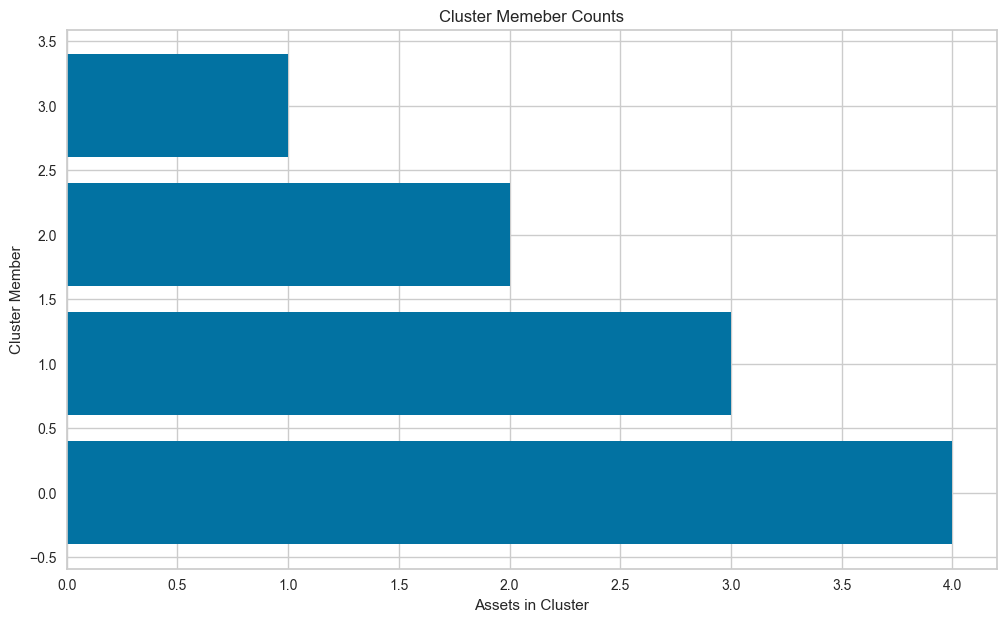

In [59]:
plt.figure(figsize = (12, 7))
plt.barh(range(len(clustered_series.value_counts())), clustered_series.value_counts())
plt.title("Cluster Memeber Counts")
plt.xlabel('Assets in Cluster')
plt.ylabel("Cluster Member")
plt.show()

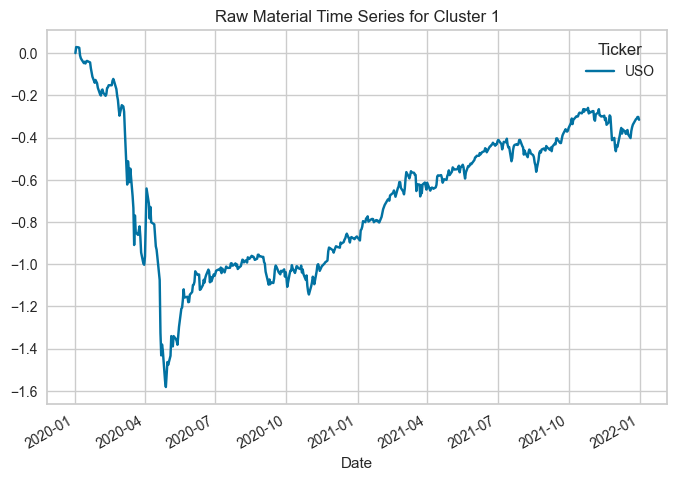

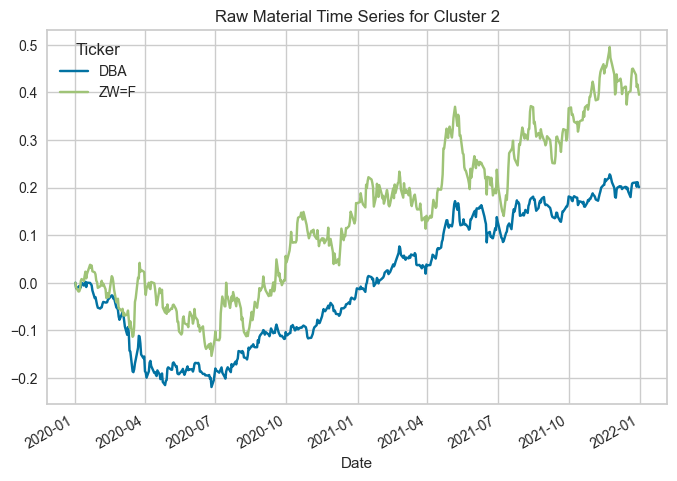

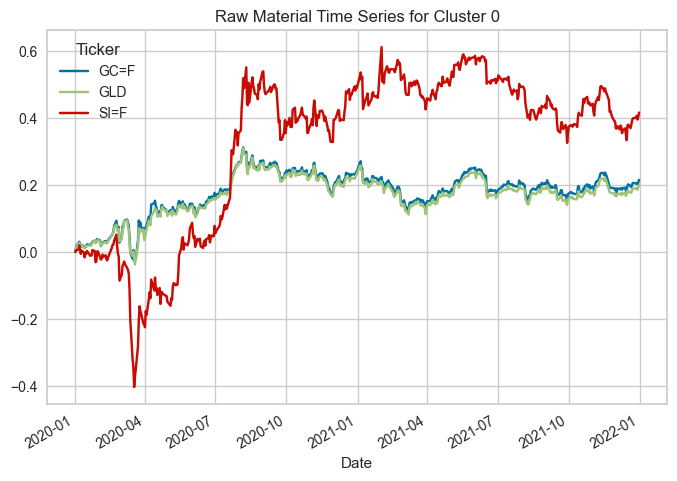

In [62]:
# Count the number of assets in each cluster
counts = clustered_series.value_counts()

# Select clusters with asset counts less than 5 and greater than 1
clusters_viz_list = list(counts[(counts < 5) & (counts > 1)].index)[::-1]

for c in clusters_viz_list:
    # Retrieve the list of assets (raw materials) in the current cluster
    assets = list(clustered_series[clustered_series == c].index)

    # Calculate cumulative returns for assets in the cluster
    cumulative_returns = in_sample_ret[assets].cumsum().fillna(0)

    # Apply a filter to exclude assets with cumulative returns exceeding the 90th percentile
    threshold = cumulative_returns.max().quantile(0.9)  # Filter assets with max cumulative returns in the top 10%
    filtered_returns = cumulative_returns.loc[:, cumulative_returns.max() < threshold]

    # Plot the filtered cumulative returns
    if not filtered_returns.empty:
        filtered_returns.plot(title=f'Raw Material Time Series for Cluster {c}')
        plt.show()
    else:
        print(f"No valid assets to plot for Cluster {c} due to all exceeding threshold.")


### Step 2: Data Pairs Selection by Cluster
To select correlated asset pairs within each cluster, follow these steps:

#### Step 2.1: Compute Correlations
- Calculate Correlations: 
Use daily returns to compute the correlation matrix for assets in each cluster.

#### Step 2.2: Select Top Pairs
- Filter Pairs: 
Choose pairs with absolute correlations >= 0.9.
- Top N Pairs: 
Select the top n pairs with the highest correlations for each asset.

In [63]:
print(clustered_series)

Ticker
CL=F    1
DBA     2
GC=F    0
GLD     0
NG=F    3
SI=F    0
USO     1
XME     0
ZC=F    2
ZW=F    2
dtype: int32


In [ ]:
def select_pairs_by_cluster(in_sample_ret, clustered_series, top_n=5, corr_threshold=0.9):
    """
    Select top correlated pairs within each cluster based on the correlation threshold.

    Parameters:
    assets_px (DataFrame): DataFrame containing price data of assets with datetime index.
    clustered_series (Series): Series where index is asset names and values are cluster labels.
    top_n (int): The number of top pairs to select for each asset.
    corr_threshold (float): The threshold for absolute correlation to consider a pair.

    Returns:
    dict: A dictionary with cluster labels as keys and a list of unique correlated pairs as values.
    """
    # Initialize a dictionary to store final pairs for each cluster
    cluster_pairs = {}

    # Iterate over each cluster group
    for cluster_label, assets_in_cluster in clustered_series.groupby(clustered_series):
        print(f"\nProcessing Cluster {cluster_label}:")

        # Filter the price data for the current cluster
        cluster_ret = in_sample_ret[assets_in_cluster.index]
        
        # Compute the correlation matrix for the current cluster
        corr_matrix = cluster_ret.corr()
        
        # Initialize a set to store unique pairs for this cluster
        final_pairs_set = set()

        # Iterate over each asset in the correlation matrix
        for asset in corr_matrix.columns:
            # Sort the pairs by the absolute value of the correlation (higher absolute correlation is better)
            sorted_pairs = corr_matrix[asset].sort_values(ascending=False, key=abs)
            
            # Filter pairs with absolute correlation >= corr_threshold and exclude the asset itself
            filtered_pairs = sorted_pairs[(sorted_pairs.abs() >= corr_threshold) & (sorted_pairs.index != asset)]
            
            # Select the top `n` pairs for this asset
            top_pairs = filtered_pairs.head(top_n)
#             print(top_pairs)
            
            # Add the selected pairs to the final set
            for pair in top_pairs.index:
                final_pairs_set.add(tuple(sorted((asset, pair))))

        # Convert the set to a sorted list
        final_pairs = sorted(final_pairs_set)
        
        # Store the final pairs for this cluster
        cluster_pairs[cluster_label] = final_pairs
        
        # Display the final pairs and the count
        print(f"Final pairs to be traded in Cluster {cluster_label}: {final_pairs}")
        print(f"Number of pairs to be traded in Cluster {cluster_label}: {len(final_pairs)}")

    return cluster_pairs

In [68]:
# cluster_pairs = select_pairs_by_cluster(in_sample_ret, clustered_series, top_n=1, corr_threshold=0.9)
cluster_pairs = select_pairs_by_cluster(in_sample_ret.cumsum(), clustered_series, top_n=1, corr_threshold=0.9)


Processing Cluster 0:
Final pairs to be traded in Cluster 0: [('GC=F', 'GLD')]
Number of pairs to be traded in Cluster 0: 1

Processing Cluster 1:
Final pairs to be traded in Cluster 1: []
Number of pairs to be traded in Cluster 1: 0

Processing Cluster 2:
Final pairs to be traded in Cluster 2: [('DBA', 'ZC=F'), ('DBA', 'ZW=F')]
Number of pairs to be traded in Cluster 2: 2

Processing Cluster 3:
Final pairs to be traded in Cluster 3: []
Number of pairs to be traded in Cluster 3: 0


In [69]:
# Combine all pairs from each cluster into a single set of unique pairs
final_pairs_set = set()

# Iterate over each cluster's pairs
for cluster_label, pairs in cluster_pairs.items():
    # Add each pair to the final set
    final_pairs_set.update(pairs)

# Convert the set to a sorted list
final_pairs = sorted(final_pairs_set)

# Print the final combined pairs and their count
print(f"Final combined pairs to be traded: {final_pairs}")
print(f"Total number of unique pairs to be traded: {len(final_pairs)}")

Final combined pairs to be traded: [('DBA', 'ZC=F'), ('DBA', 'ZW=F'), ('GC=F', 'GLD')]
Total number of unique pairs to be traded: 3


### Step 3: Trading Strategy

For the backtesting period from January 1, 2022, to the present, we implement the following strategy to each selected pair:

#### 1. Signal Generation

- **Residual Calculation**:

$$
\epsilon_t = \log(p_{i,t}) - (\beta_t \cdot \log(p_{j,t}) + \alpha_t)
$$

  - where:
    - \( \log(p_{i,t}) \) and \( \log(p_{j,t}) \) are the log prices of assets \( i \) and \( j \) at time \( t \).
    - \( \beta_t \) is calculated as:
      $$
      \beta_t = \text{Corr}_t \times \frac{\text{Vol}_{j,t}}{\text{Vol}_{i,t}}
      $$
      - with:
        - \( \text{Corr}_t \): the 90-day rolling correlation between \( \log(p_{i,t}) \) and \( \log(p_{j,t}) \).
        - \( \text{Vol}_{i,t} \): the 90-day rolling volatility of \( \log(p_{i,t}) \).
        - \( \text{Vol}_{j,t} \): the 90-day rolling volatility of \( \log(p_{j,t}) \).

    - \( \alpha_t \) is calculated as:
      $$
      \alpha_t = \mu_{\log(p_{i,t},90)} - \beta_t \cdot \mu_{\log(p_{j,t},90)}
      $$
      - where:
        - \( \mu_{\log(p_{i,t},90)} \): the 90-day rolling mean of \( \log(p_{i,t}) \).
        - \( \mu_{\log(p_{j,t},90)} \): the 90-day rolling mean of \( \log(p_{j,t}) \).

---

- **Z-Score Calculation**:

$$
z_t = \frac{\epsilon_t - \mu_t}{\sigma_t}
$$

  - where:
    - \( \mu_t \): the 90-day rolling mean of the spread (\( \epsilon_t \)).
    - \( \sigma_t \): the 90-day rolling standard deviation of the spread (\( \epsilon_t \)).


### 2. Portfolio Construction

- **Entry Signals**:
  - **Short** asset \( i \) and **long** \( \beta_t \) units of asset \( j \) if \( z_t > 1 \).
  - **Long** asset \( i \) and **short** \( \beta_t \) units of asset \( j \) if \( z_t < -1 \).

- **Exit Signals**:
  - Close the position when \( z_t \) moves to any of the following thresholds:
    $$
    z_t \geq -\text{threshold} \quad \text{or} \quad z_t \leq \text{threshold}
    $$

  - where **threshold** is one of the values: 0.1, 0.2, 0.5, or 0.7.


In [70]:
def gen_signals(px, pairs, window=90):
    signal_df = {}
    
    for pair in pairs:
        asset_i, asset_j = pair
        
        # Forward-fill missing values and replace zeros with NaNs
        px_i = px[asset_i].replace(0, np.nan).ffill()
        px_j = px[asset_j].replace(0, np.nan).ffill()
        
        # Apply log transformation
        log_px_i = np.log(px_i)
        log_px_j = np.log(px_j)
        
        # Calculate rolling covariance and variance 
        rolling_cov = log_px_i.rolling(window=window, min_periods=1).cov(log_px_j)
        rolling_var = log_px_i.rolling(window=window, min_periods=1).var()
        
        # Calculate beta and alpha
        beta = rolling_cov / rolling_var
        alpha = log_px_j.rolling(window=window).mean() - beta * log_px_i.rolling(window=window).mean()
        
        # Calculate spread for time t using beta and alpha
        spread = log_px_i - (beta * log_px_j + alpha)
        
        # Calculate rolling mean and standard deviation of the spread using data up to t
        spread_mean = spread.rolling(window=window, min_periods=1).mean()
        spread_std = spread.rolling(window=window, min_periods=1).std()
        
        # Calculate the z-score for time t using spread(t), mean(t), and std(t)
        z_score = (spread - spread_mean) / spread_std
        
        # Store beta, alpha, spread, and z-score in a multi-level column DataFrame
        signal_df[(pair, 'beta')] = beta
        signal_df[(pair, 'alpha')] = alpha
        signal_df[(pair, 'spread')] = spread
        signal_df[(pair, 'z_score')] = z_score
    
    # Convert the dictionary to a DataFrame
    signal_df = pd.DataFrame(signal_df)
    
    return signal_df

In [73]:
def gen_port(signal_df, pairs, threshold=0.5):
    # Initialize a DataFrame with the same index and columns as raw_materials_prices, filled with NaN
    pos = pd.DataFrame(index=signal_df.index, columns=raw_materials_prices.columns)
    for pair in pairs:
        asset_i, asset_j = pair
        # Access z-scores and betas for this pair
        z_scores = signal_df[(pair, 'z_score')]
        betas = signal_df[(pair, 'beta')]

        # Set positions based on z-scores
        pos.loc[z_scores > 1, asset_i] = -1  # Short one unit of asset_i
        pos.loc[z_scores < -1, asset_i] = 1  # Long one unit of asset_i
        pos.loc[(z_scores.abs() <= threshold), asset_i] = 0  # Exit signal

        pos.loc[z_scores > 1, asset_j] = betas  # Long beta units of asset_j
        pos.loc[z_scores < -1, asset_j] = -betas  # Short beta units of asset_j
        pos.loc[(z_scores.abs() <= threshold), asset_j] = 0  # Exit signal

    # Forward-fill missing values
    pos = pos.ffill()
    # Normalize to ensure a fully-invested portfolio
    pos = pos.divide(pos.abs().sum(axis=1), axis=0).fillna(0)
    return pos

### Step 4: Performance Evaluation
We evaluate the strategy's performance across four exit thresholds: 0.1, 0.2, 0.5, and 0.7. For each threshold, the following key metrics are calculated:

- Sharpe Ratio: Risk-adjusted return of the strategy.
- Transaction Costs: Average costs incurred due to trading.
- Holding Period: Average number of days a position is held.
- Turnover: Average daily proportion of the portfolio that is traded.
- Annualized Return: Average yearly return of the strategy.
- Annualized Volatility: Standard deviation of returns on an annual basis, indicating risk.
- Raw materials typically have lower commission rates, ranging around 3 bps (0.03%). Slippage, while variable depending on market conditions and trade volume, is generally estimated at 10 bps (0.1%). Thus, the total all-in execution cost for raw materials is approximately 13 bps (0.13%) for market orders.

In [75]:
# Define the thresholds and initialize the arrays for storing metrics
thresholds = [0.1, 0.2, 0.5, 0.7]
metrics = {
    'Sharpe Ratio': np.zeros(len(thresholds)),
    'Return': np.zeros(len(thresholds)),
    'Volatility': np.zeros(len(thresholds)),
    'Holding Period': np.zeros(len(thresholds)),
    'Turnover': np.zeros(len(thresholds)),
    'Transaction Costs': np.zeros(len(thresholds)),
}

# Set the start of the out-of-sample period
start_of_out_sample = end_of_insample + pd.DateOffset(days=1)

# Loop over each threshold to calculate metrics
for i, threshold in enumerate(thresholds):
    # Generate signals
    signal_df = gen_signals(raw_materials_prices, final_pairs, window=90)
    signal_df = signal_df.loc[start_of_out_sample:]
    
    # Generate portfolio
    port = gen_port(signal_df, final_pairs, threshold)
    
    # Calculate out-of-sample daily returns
    out_sample_ret = raw_ret.loc[start_of_out_sample:][port.columns]
    strat_gross_ret = (port.shift() * out_sample_ret).sum(1)
    
    # Calculate net returns
    to = compute_turnover(port)
    tcost_bps = 13  # (commissions + slippage)
    strat_net_ret = strat_gross_ret.subtract(to * tcost_bps * 1e-4, fill_value=0)
    
    # Compute Sharpe ratio
    sharpe_ratio = compute_sharpe_ratio(strat_net_ret)
    metrics['Sharpe Ratio'][i] = sharpe_ratio
    
    # Compute transaction costs
    total_tcost = to * tcost_bps * 1e-4
    metrics['Transaction Costs'][i] = total_tcost.sum()
    
    # Compute holding period (average number of days a position is held)
    metrics['Holding Period'][i] = 2/to.mean()
    
    # Store turnover
    metrics['Turnover'][i] = to.mean()
    
    # Compute return 
    returns = strat_net_ret.mean()
    metrics['Return'][i] = returns
    
    # Compute volatility
    volatility = strat_net_ret.std()
    metrics['Volatility'][i] = volatility
    
# Convert metrics to a DataFrame for easier visualization
metrics_df = pd.DataFrame(metrics, index=thresholds)

# Display the results
print(metrics_df)

     Sharpe Ratio    Return  Volatility  Holding Period  Turnover  \
0.1      0.099558  0.000057    0.009128       23.659938  0.084531   
0.2     -0.016451 -0.000009    0.008324       21.475123  0.093131   
0.5     -0.339183 -0.000180    0.008436       18.259527  0.109532   
0.7      0.067526  0.000040    0.009449       16.837203  0.118785   

     Transaction Costs  
0.1           0.082638  
0.2           0.091045  
0.5           0.107078  
0.7           0.116124  


In [82]:
signal_df = gen_signals(raw_materials_prices, final_pairs, window=90)
signal_df = signal_df.loc[start_of_out_sample:]
signal_df.head()


(DBA, ZC=F)                                (DBA, ZW=F)            \
                  beta     alpha     spread   z_score        beta     alpha   
Date                                                                          
2022-01-03    2.049563  0.427333 -10.611735 -1.580956    2.258837  0.139065   
2022-01-04    2.076480  0.350320 -10.769994 -1.565831    2.238331  0.197856   
2022-01-05    2.093487  0.301846 -10.811100 -1.531671    2.224194  0.238653   
2022-01-06    2.110149  0.254853 -10.877019 -1.502843    2.209309  0.281654   
2022-01-07    2.124761  0.213409 -10.931065 -1.473208    2.172049  0.388664   

                                (GC=F, GLD)                                
               spread   z_score        beta     alpha    spread   z_score  
Date                                                                       
2022-01-03 -12.227241 -0.950195    0.969748 -2.143166  4.667516 -1.149947  
2022-01-04 -12.178632 -0.889694    0.969802 -2.143574  4.668611 -1.092386  
2022-01-05 -12.104161 -0.808585    0.962591 -2.089674  4.660456 -1.321550  
2022-01-06 -12.006173 -0.708550    0.962039 -2.085576  4.651169 -1.571538  
2022-01-07 -11.894205 -0.597194    0.961585 -2.082197  4.650377 -1.553700

<Axes: xlabel='Date'>

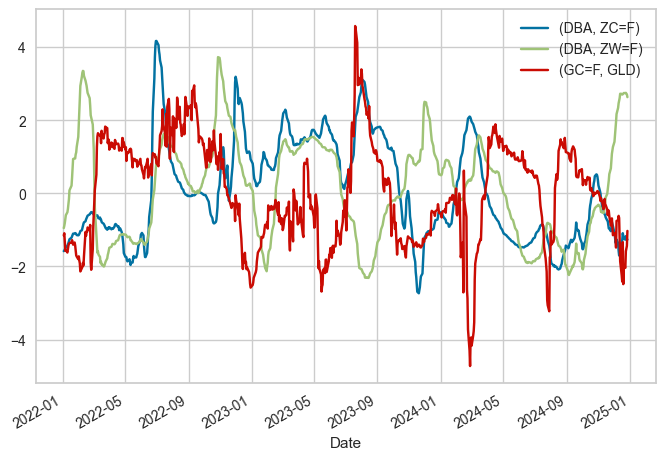

In [83]:
# plot the z-score
z_score_df = signal_df.xs('z_score', axis=1, level=1)
z_score_df.plot()

In [84]:
# portfolio construction
port = gen_port(signal_df, final_pairs, 0.1)
port.head()

Ticker,CL=F,DBA,GC=F,GLD,NG=F,SI=F,USO,XME,ZC=F,ZW=F
Date,,,,,,,,,,
2022-01-03,0.0,0.199231,0.199231,-0.193203,0.0,0.0,0.0,0.0,-0.408336,0.0
2022-01-04,0.0,0.198166,0.198166,-0.192182,0.0,0.0,0.0,0.0,-0.411487,0.0
2022-01-05,0.0,0.197782,0.197782,-0.190383,0.0,0.0,0.0,0.0,-0.414054,0.0
2022-01-06,0.0,0.197154,0.197154,-0.189669,0.0,0.0,0.0,0.0,-0.416023,0.0
2022-01-07,0.0,0.196605,0.196605,-0.189052,0.0,0.0,0.0,0.0,-0.417738,0.0


The threshold of 0.1 was chosen for its conservative approach, yielding the highest positive return (0.000057) with the lowest transaction costs (0.082638) and the longest holding period (23.66 days). 

This minimizes trading frequency, reduces costs, and ensures stability, making it the most suitable choice for a low-risk strategy.

<Axes: xlabel='Date'>

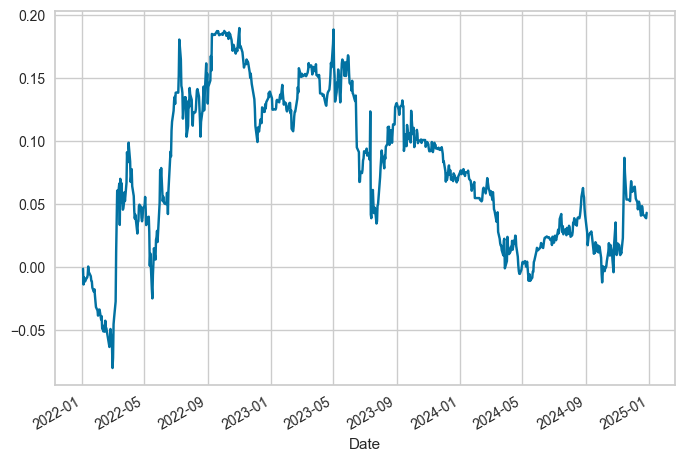

In [92]:
# Calculate out-of-sample daily returns
out_sample_ret = raw_ret.loc[start_of_out_sample:][port.columns]
strat_gross_ret = (port.shift() * out_sample_ret).sum(1)

# Calculate net returns
to = compute_turnover(port)
tcost_bps = 13  # (commissions + slippage)
strat_net_ret = strat_gross_ret.subtract(to * tcost_bps * 1e-4, fill_value=0)

strat_net_ret.cumsum().plot()

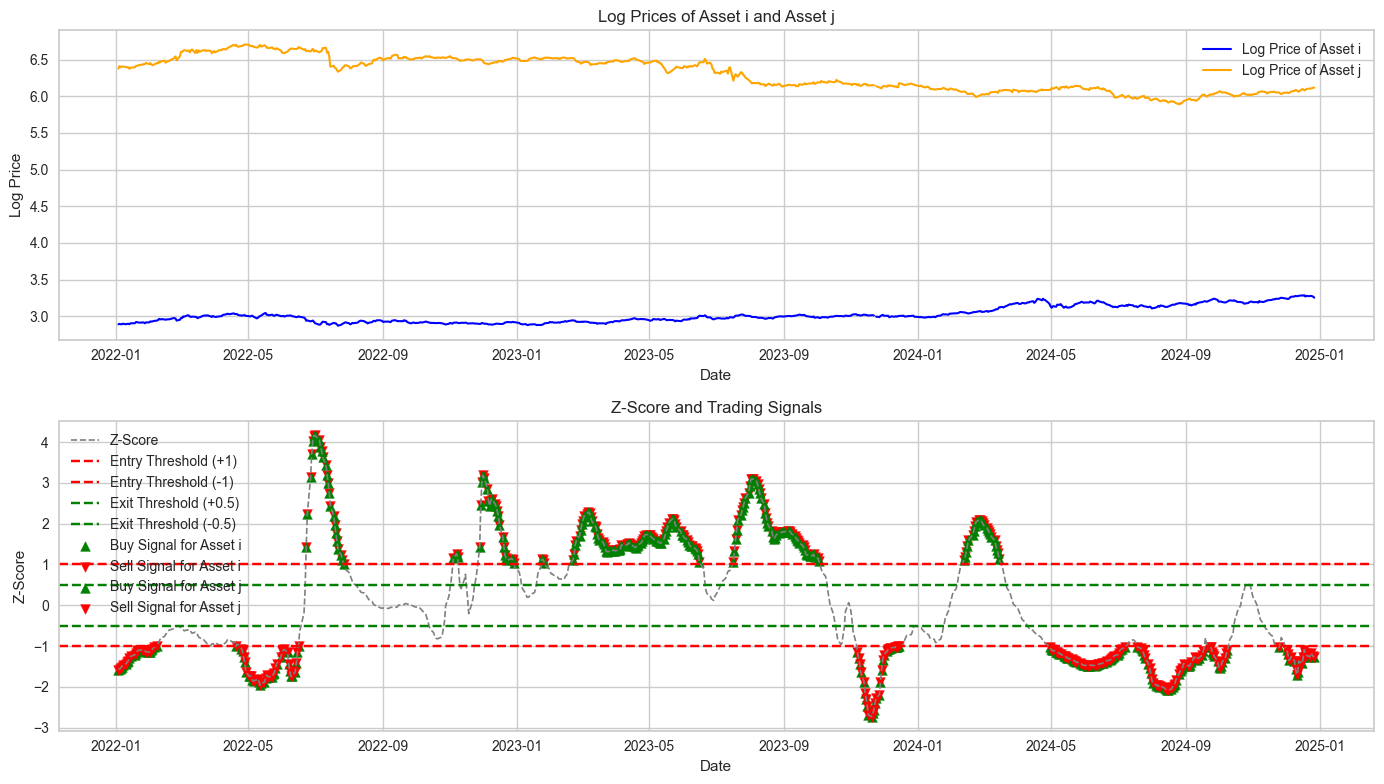

In [93]:
# select a random pair and visualize their log-prices and z-scores 
asset_i, asset_j = final_pairs[0] 
log_px_i = np.log(raw_materials_prices.loc[start_of_out_sample:][asset_i])
log_px_j = np.log(raw_materials_prices.loc[start_of_out_sample:][asset_j])
z_score = signal_df[(final_pairs[0], 'z_score')]

plot_with_signals(log_px_i, log_px_j, z_score)

In [100]:
buy_and_hold_corn = raw_ret['ZC=F'][start_of_out_sample:]
buy_and_hold_corn

Date
2022-01-03   -0.006743
2022-01-04    0.034366
2022-01-05   -0.011895
2022-01-06    0.002491
2022-01-07    0.004969
                ...   
2024-12-20    0.012479
2024-12-23    0.003361
2024-12-24    0.001675
2024-12-26    0.011706
2024-12-27    0.000000
Name: ZC=F, Length: 752, dtype: float64

In [ ]:
# Updated compute_stats function to return a DataFrame
def compute_stats(df):
    stats = {
        'mean': df.mean(),
        'std': df.std(),
        'sharpe': df.mean() / df.std(),
    }
    return pd.DataFrame(stats)

# Full-sample returns comparison
full_sample_ret = pd.DataFrame({
    'strat_ret': strat_net_ret,
    'buy_and_hold_corn': buy_and_hold_corn
})

# Compute the statistics and display
full_sample_stats = compute_stats(full_sample_ret)
full_sample_stats

,mean,std,sharpe
strat_ret,0.000057,0.009128,0.006272
buy_and_hold_corn,-0.000182,0.017675,-0.010318


<Axes: xlabel='Date'>

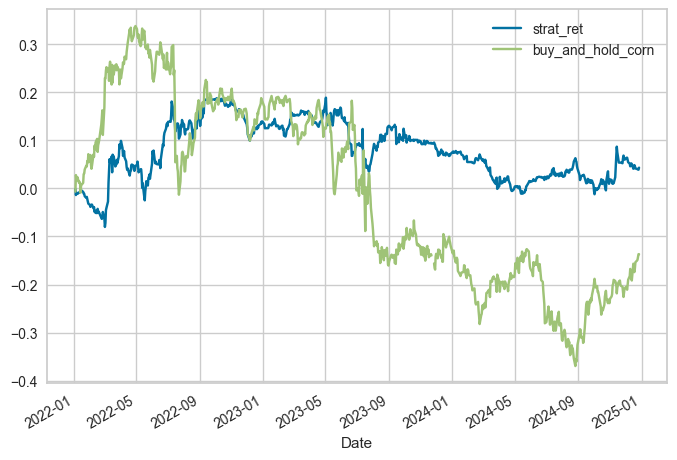

In [106]:
full_sample_ret.cumsum().plot()

In [107]:
corr = full_sample_ret.rolling(252).corr(full_sample_ret['buy_and_hold_corn'])
vol = full_sample_ret.rolling(252).std()

beta = (corr*vol).divide(vol['buy_and_hold_corn'], 0)

# Computing Point-in-Time Residual Returns
resid = full_sample_ret - beta.multiply(full_sample_ret['buy_and_hold_corn'], axis=0)
print(resid)
print(resid.corr())

# The information ratio
IR = resid.mean()/resid.std()*np.sqrt(252)
print(f"Information ratio is {IR['strat_ret']}")

            strat_ret  buy_and_hold_corn
Date                                    
2022-01-03        NaN                NaN
2022-01-04        NaN                NaN
2022-01-05        NaN                NaN
2022-01-06        NaN                NaN
2022-01-07        NaN                NaN
...               ...                ...
2024-12-20  -0.001277      -9.367507e-17
2024-12-23   0.000572      -2.558717e-17
2024-12-24  -0.000728      -1.257675e-17
2024-12-26   0.002428      -8.847090e-17
2024-12-27   0.004290       0.000000e+00

[752 rows x 2 columns]
                   strat_ret  buy_and_hold_corn
strat_ret           1.000000           0.338417
buy_and_hold_corn   0.338417           1.000000
Information ratio is -0.30738209540670247


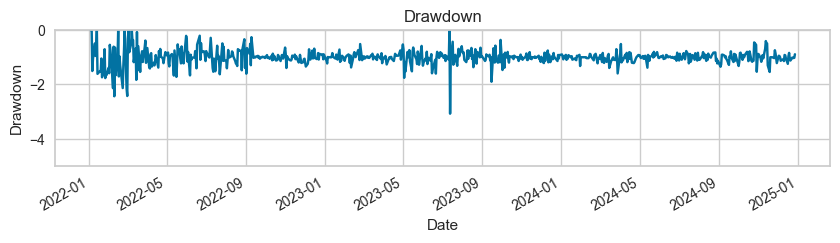

The max drawdown is -3.0752247705551183


In [108]:
# max drawdown
dd = drawdown(full_sample_ret['strat_ret'])
plt.figure(figsize=(10, 2))
dd.plot()
plt.ylim(-5, 0)
plt.title('Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.show()
print(f"The max drawdown is {dd.min()}")

In [109]:
ddd = duration(full_sample_ret.cumsum())
ddd

,strat_ret,buy_and_hold_corn
Date,,
2022-01-03,0,0
2022-01-04,1,0
2022-01-05,2,1
2022-01-06,3,2
2022-01-07,4,3
...,...,...
2024-12-20,538,666
2024-12-23,539,667
2024-12-24,540,668


<Axes: xlabel='Date'>

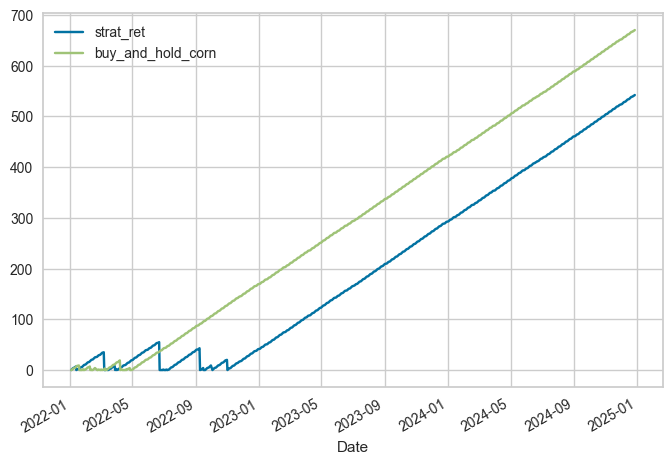

In [110]:
ddd.plot()

In [111]:
# maximum drawdown duration
ddd.max()

strat_ret            542
buy_and_hold_corn    670
dtype: object